In [1]:
from xsmc import XSMC, Segmentation
import numpy as np
from scipy.stats import sem
from scipy.interpolate import PPoly
import pandas as pd

import msprime as msp
import stdpopsim

import os
import psutil
import time

In [5]:
import matplotlib
%matplotlib inline
matplotlib.rcParams.update({
    'font.family': 'Times New Roman',
    'text.usetex': True,
})
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as pn
from plotnine import *

In [3]:
folder = '../../../exact_decoding_paper/figures/benchmark/'

### Bayesian vs MAP

Functions needed to run simulations

In [5]:
def plot_scenario(r, mu, N0, constant, seed, ax, plot_label, **kwargs):
    theta = mu * N0
    rho = r * N0
    ts = simulate(2, r, constant, seed)
    
    truth = Segmentation.from_ts(ts, 0, [1])
    truth.draw(axis=ax, color="red", label='Truth')
    
    xs = XSMC(ts, focal=0, panel=[1], theta=theta, rho_over_theta=rho/theta)
    
    rescale = xs.theta / (2 * 1e-8)
    b_paths = xs.sample(k=200, seed=seed)
    b_paths = [path.rescale(rescale) for path in b_paths]
    kwargs.setdefault("alpha", 2 / len(b_paths))
    for p in b_paths:
        p.draw(axis=ax, color="blue", alpha=kwargs["alpha"])
        
    x = np.arange(xs.ts.sequence_length)
    y = np.median([path.to_pp()(x) for path in b_paths], axis=0)
    ymin = np.amin(y)
    ymax = np.amax(y)
    ax.plot(y, color='purple', label='Posterior Median')
    
    map_path = xs.viterbi(-np.log(xs.rho))
    map_path = map_path.rescale(rescale) 
    map_path.draw(axis=ax, color='green', label='MAP')
    
    ax.set_xlim(0, ts.sequence_length * 1e-9/r)    
    ax.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
    ax.set_yscale("log")
    
    ax.xaxis.set_tick_params(labelsize=size)
    ax.yaxis.set_tick_params(labelsize=size)
    ax.xaxis.offsetText.set_fontsize(size)
    ax.legend(loc = 'lower right', prop={'size': size})

    ax.text(0.01, .99, plot_label, transform=ax.transAxes,
            fontsize=size, va='top')
    sns.despine()
    
    return ymin, ymax


def simulate(n, recombination_rate, constant = True, seed = 1):
    if constant:
        de = None
    else:
        de = [msp.PopulationParametersChange(time=0, initial_size=100 * N0),
            msp.PopulationParametersChange(time=1000, initial_size=0.5 * N0),
            msp.PopulationParametersChange(time=3612, initial_size=N0)]

    return msp.simulate(
        sample_size=n,
        mutation_rate=mu,
        recombination_rate=recombination_rate,
        Ne=N0,
        length=L,
        demographic_events=de,
        random_seed=seed,
    )

def get_truth(ts, focal, panel):
    truth = np.empty(int(ts.sequence_length))
    for tree in ts.trees():
        start = int(tree.interval[0])
        end = int(tree.interval[1])
        truth[start:end] = tree.get_tmrca(focal, panel)
    return truth

def get_dist(truth, y):
    L = truth.size
    err_A = np.abs(truth - y).sum()/L
    err_B = np.abs(np.log10(truth/y)).sum()/L
    return err_A, err_B

def get_map_path(xs):
    path = xs.viterbi(-np.log(xs.rho))
    x = np.arange(xs.ts.sequence_length)
    y = path.rescale(xs.theta / (2 * 1e-8)).to_pp()(x) 
    return y

def get_b_path(xs, seed):
    paths = xs.sample(k=200, seed=seed)
    x = np.arange(xs.ts.sequence_length)
    y = np.median([path.rescale(xs.theta / (2 * 1e-8)).to_pp()(x) for path in paths], axis=0)
    return y

def one_run(ts, focal, panel, rho_over_theta, seed):
    xs = XSMC(ts, focal=focal, panel=panel, rho_over_theta=rho_over_theta)
    map_path = get_map_path(xs)
    b_path = get_b_path(xs, seed)
    truth = get_truth(ts, focal, panel[0])
    err_A_map, err_B_map = get_dist(truth, map_path)
    err_A_b, err_B_b = get_dist(truth, b_path)
    return err_A_map, err_A_b, err_B_map, err_B_b  

def run_sim(num_sim, r, constant, seed):
    ts = simulate(2*num_sim, r, constant, seed)
    err_mat = [one_run(ts=ts, focal=2 * i, panel=[2 * i + 1], 
                       rho_over_theta = r/mu, seed=seed) for i in range(num_sim)]
    return np.array(err_mat).T

def save_table(tab, name):
    index_list = ['1','2','3','4']
    tab['Scenario'] = index_list
    tab = tab.set_index('Scenario').T
    tab.to_latex(folder + name)
    display(tab)
    
def format_entry(mean, se, dec_places):
    entry = f'{mean:.{dec_places}f} ({se:.{dec_places}f})'
    return entry
                                      
mfunc = np.vectorize(format_entry)

Simulations Parameters

In [7]:
num_sim = 25
N0 = 1e4 #base effective population size
mu = 1.4e-8 #mutation rate
L = 1_000_000 #sequence length

In [8]:
plot_seed = 6
rs = [1e-9] * 2 + [1.4e-8] * 2
constants = [True, False] * 2

#### Plot one run for each scenario

2020-09-10 10:16:59,748 DEBUG xsmc.xsmc MainThread Setting window size w=1000.000000
2020-09-10 10:16:59,749 DEBUG xsmc._sampler MainThread Counting mismatches for focal=0 panel=[1]
2020-09-10 10:16:59,750 DEBUG xsmc._sampler MainThread Sampling paths
2020-09-10 10:16:59,750 DEBUG xsmc._sampler MainThread Computing log Q
2020-09-10 10:16:59,751 DEBUG xsmc._sampler MainThread Xcs.shape=(1, 1002) positions=[0.000e+00 1.000e+00 2.000e+00 ... 9.990e+02 1.000e+03 1.001e+03] params={'theta': 0.14000000059604645, 'rho': 0.009999999776482582, 'eps': 9.999999747378752e-05, 'robust': False, 'use_cache': False}
2020-09-10 10:16:59,772 DEBUG xsmc._sampler MainThread Done computing log Q
2020-09-10 10:16:59,782 DEBUG xsmc._sampler MainThread Done sampling paths.
2020-09-10 10:16:59,789 DEBUG xsmc.sampler MainThread Sampling heights
2020-09-10 10:16:59,800 DEBUG xsmc.sampler MainThread Done sampling heights
2020-09-10 10:17:04,103 DEBUG xsmc.xsmc MainThread Setting window size w=1000.000000
2020-09-

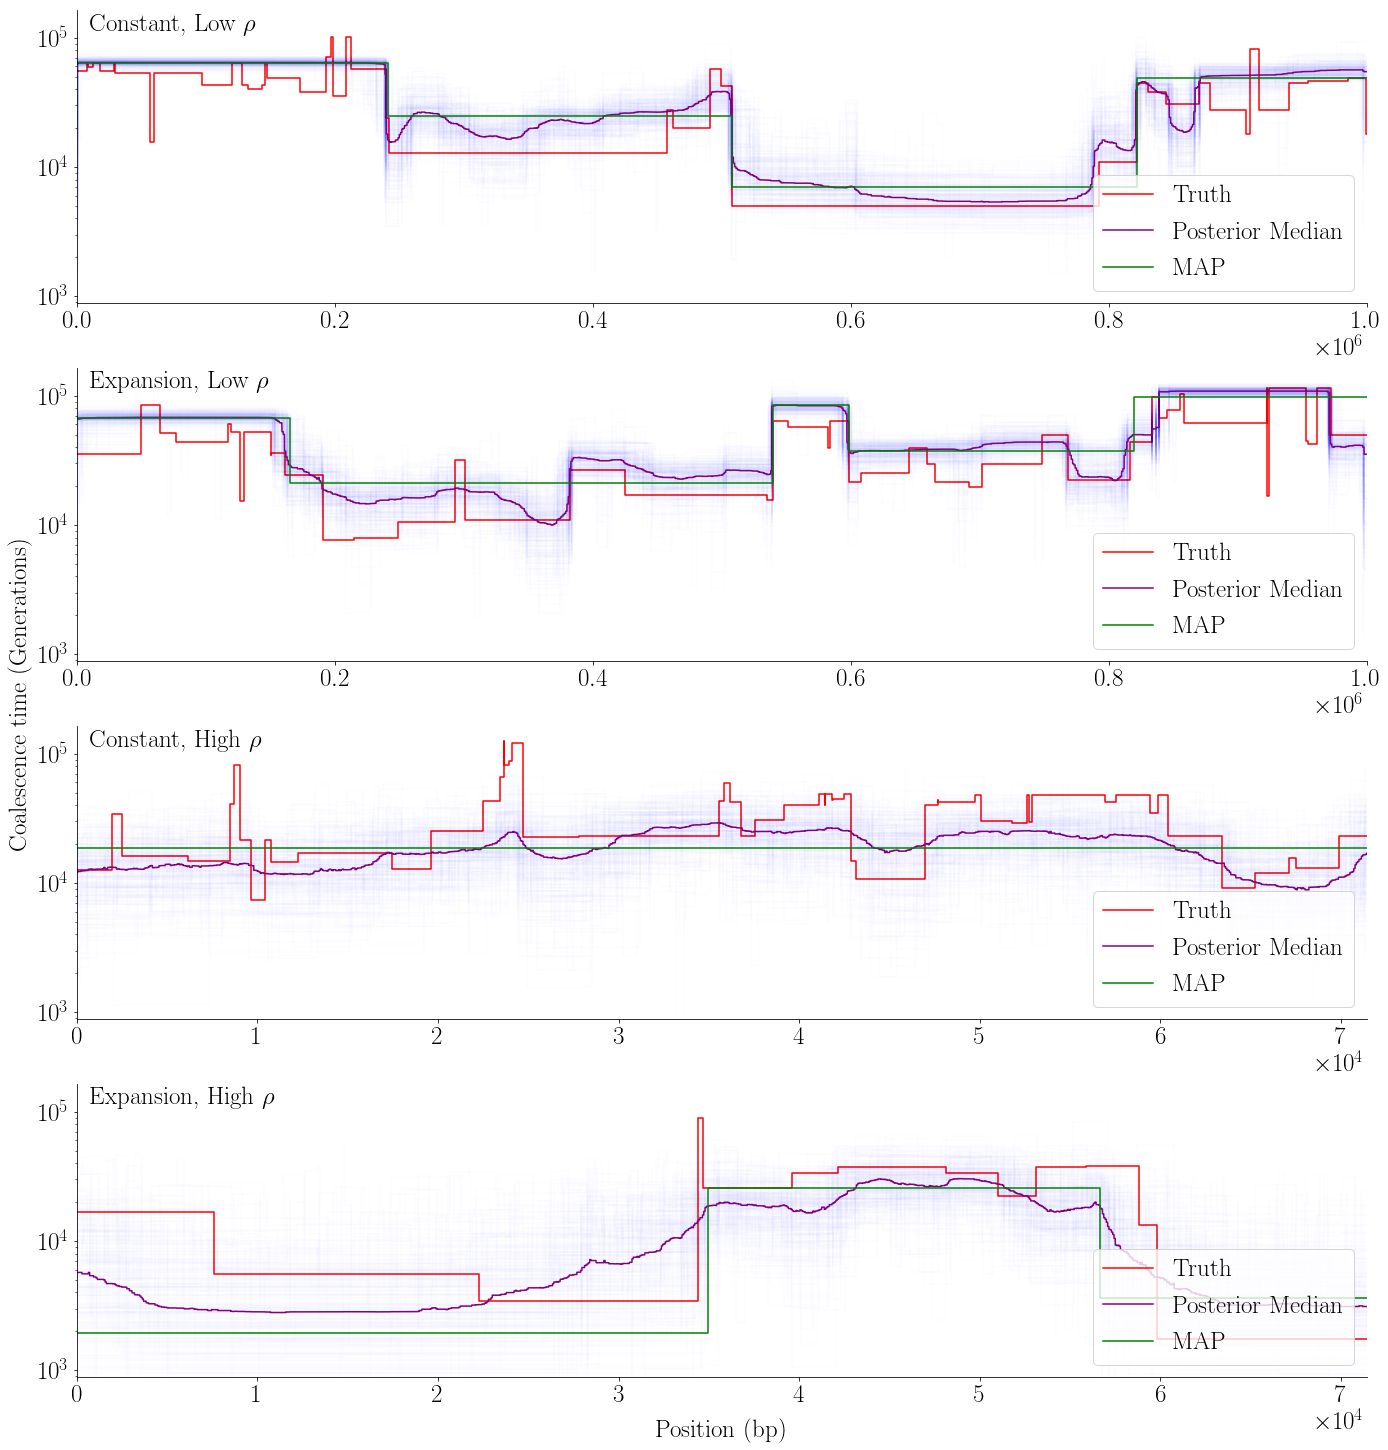

In [9]:
size = 25

fig, axs = plt.subplots(4, figsize=(20, 21), sharey=True)
fig.add_subplot(111, frameon=False)

plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plot_labels = [r'Constant, Low $\rho$', r'Expansion, Low $\rho$', 
               r'Constant, High $\rho$', r'Expansion, High $\rho$']

ymin = float('inf')
ymax = 0
for i, ax in enumerate(axs):
    y1, y2 = plot_scenario(rs[i], mu, N0, constants[i], plot_seed, ax, plot_labels[i])
    if y1 < ymin:
        ymin = y1
    if y2 > ymax:
        ymax = y2

plt.setp(ax.get_xticklabels(), fontsize=size)   
plt.setp(ax.get_yticklabels(), fontsize=size)
plt.setp(ax, ylim=(0.75 * ymin, 1.5 * ymax))

plt.xlabel('Position (bp)', fontsize=size, labelpad = size)
plt.ylabel('Coalescence time (Generations)', fontsize=size, labelpad = size)
plt.tight_layout()
plt.savefig(folder + 'bayesian_vs_map.pdf', bbox_inches='tight')
plt.draw()

#### Run simulation and create table

In [68]:
table_seed = 6
err_mats = np.empty((4, 4, num_sim))
for i in range(4):
    err_mats[i] = run_sim(num_sim, rs[i], constants[i], table_seed)

2020-09-09 17:48:14,677 DEBUG xsmc.xsmc MainThread Estimated θ=0.000584
2020-09-09 17:48:14,678 DEBUG xsmc.xsmc MainThread Setting window size w=239.000000
2020-09-09 17:48:14,710 DEBUG xsmc._sampler MainThread Counting mismatches for focal=0 panel=[1]
2020-09-09 17:48:14,714 DEBUG xsmc._sampler MainThread Sampling paths
2020-09-09 17:48:14,715 DEBUG xsmc._sampler MainThread Computing log Q
2020-09-09 17:48:14,716 DEBUG xsmc._sampler MainThread Xcs.shape=(1, 4186) positions=[0.000e+00 1.000e+00 2.000e+00 ... 4.183e+03 4.184e+03 4.185e+03] params={'theta': 0.13953033089637756, 'rho': 0.009966452606022358, 'eps': 9.999999747378752e-05, 'robust': False, 'use_cache': False}
2020-09-09 17:48:14,892 DEBUG xsmc._sampler MainThread Done computing log Q
2020-09-09 17:48:14,937 DEBUG xsmc._sampler MainThread Done sampling paths.
2020-09-09 17:48:14,942 DEBUG xsmc.sampler MainThread Sampling heights
2020-09-09 17:48:14,953 DEBUG xsmc.sampler MainThread Done sampling heights
2020-09-09 17:48:20,28

2020-09-09 17:48:57,680 DEBUG xsmc._sampler MainThread Xcs.shape=(1, 4186) positions=[0.000e+00 1.000e+00 2.000e+00 ... 4.183e+03 4.184e+03 4.185e+03] params={'theta': 0.13953033089637756, 'rho': 0.009966452606022358, 'eps': 9.999999747378752e-05, 'robust': False, 'use_cache': False}
2020-09-09 17:48:57,857 DEBUG xsmc._sampler MainThread Done computing log Q
2020-09-09 17:48:57,906 DEBUG xsmc._sampler MainThread Done sampling paths.
2020-09-09 17:48:57,911 DEBUG xsmc.sampler MainThread Sampling heights
2020-09-09 17:48:57,921 DEBUG xsmc.sampler MainThread Done sampling heights
2020-09-09 17:49:03,241 DEBUG xsmc.xsmc MainThread Estimated θ=0.000584
2020-09-09 17:49:03,243 DEBUG xsmc.xsmc MainThread Setting window size w=239.000000
2020-09-09 17:49:03,265 DEBUG xsmc._sampler MainThread Counting mismatches for focal=18 panel=[19]
2020-09-09 17:49:03,266 DEBUG xsmc._sampler MainThread Sampling paths
2020-09-09 17:49:03,267 DEBUG xsmc._sampler MainThread Computing log Q
2020-09-09 17:49:03,

2020-09-09 17:49:41,121 DEBUG xsmc._sampler MainThread Done sampling paths.
2020-09-09 17:49:41,126 DEBUG xsmc.sampler MainThread Sampling heights
2020-09-09 17:49:41,134 DEBUG xsmc.sampler MainThread Done sampling heights
2020-09-09 17:49:46,028 DEBUG xsmc.xsmc MainThread Estimated θ=0.000584
2020-09-09 17:49:46,028 DEBUG xsmc.xsmc MainThread Setting window size w=239.000000
2020-09-09 17:49:46,053 DEBUG xsmc._sampler MainThread Counting mismatches for focal=34 panel=[35]
2020-09-09 17:49:46,054 DEBUG xsmc._sampler MainThread Sampling paths
2020-09-09 17:49:46,055 DEBUG xsmc._sampler MainThread Computing log Q
2020-09-09 17:49:46,056 DEBUG xsmc._sampler MainThread Xcs.shape=(1, 4186) positions=[0.000e+00 1.000e+00 2.000e+00 ... 4.183e+03 4.184e+03 4.185e+03] params={'theta': 0.13953033089637756, 'rho': 0.009966452606022358, 'eps': 9.999999747378752e-05, 'robust': False, 'use_cache': False}
2020-09-09 17:49:46,227 DEBUG xsmc._sampler MainThread Done computing log Q
2020-09-09 17:49:46,

2020-09-09 17:50:33,595 DEBUG xsmc._sampler MainThread Counting mismatches for focal=0 panel=[1]
2020-09-09 17:50:33,596 DEBUG xsmc._sampler MainThread Sampling paths
2020-09-09 17:50:33,596 DEBUG xsmc._sampler MainThread Computing log Q
2020-09-09 17:50:33,597 DEBUG xsmc._sampler MainThread Xcs.shape=(1, 4653) positions=[0.000e+00 1.000e+00 2.000e+00 ... 4.650e+03 4.651e+03 4.652e+03] params={'theta': 0.13972678780555725, 'rho': 0.00998048484325409, 'eps': 9.999999747378752e-05, 'robust': False, 'use_cache': False}
2020-09-09 17:50:33,747 DEBUG xsmc._sampler MainThread Done computing log Q
2020-09-09 17:50:33,790 DEBUG xsmc._sampler MainThread Done sampling paths.
2020-09-09 17:50:33,795 DEBUG xsmc.sampler MainThread Sampling heights
2020-09-09 17:50:33,804 DEBUG xsmc.sampler MainThread Done sampling heights
2020-09-09 17:50:38,782 DEBUG xsmc.xsmc MainThread Estimated θ=0.000650
2020-09-09 17:50:38,783 DEBUG xsmc.xsmc MainThread Setting window size w=215.000000
2020-09-09 17:50:38,817

2020-09-09 17:51:17,259 DEBUG xsmc._sampler MainThread Done computing log Q
2020-09-09 17:51:17,305 DEBUG xsmc._sampler MainThread Done sampling paths.
2020-09-09 17:51:17,310 DEBUG xsmc.sampler MainThread Sampling heights
2020-09-09 17:51:17,320 DEBUG xsmc.sampler MainThread Done sampling heights
2020-09-09 17:51:22,464 DEBUG xsmc.xsmc MainThread Estimated θ=0.000650
2020-09-09 17:51:22,465 DEBUG xsmc.xsmc MainThread Setting window size w=215.000000
2020-09-09 17:51:22,491 DEBUG xsmc._sampler MainThread Counting mismatches for focal=18 panel=[19]
2020-09-09 17:51:22,493 DEBUG xsmc._sampler MainThread Sampling paths
2020-09-09 17:51:22,493 DEBUG xsmc._sampler MainThread Computing log Q
2020-09-09 17:51:22,494 DEBUG xsmc._sampler MainThread Xcs.shape=(1, 4653) positions=[0.000e+00 1.000e+00 2.000e+00 ... 4.650e+03 4.651e+03 4.652e+03] params={'theta': 0.13972678780555725, 'rho': 0.00998048484325409, 'eps': 9.999999747378752e-05, 'robust': False, 'use_cache': False}
2020-09-09 17:51:22,6

2020-09-09 17:52:06,006 DEBUG xsmc.xsmc MainThread Setting window size w=215.000000
2020-09-09 17:52:06,036 DEBUG xsmc._sampler MainThread Counting mismatches for focal=34 panel=[35]
2020-09-09 17:52:06,038 DEBUG xsmc._sampler MainThread Sampling paths
2020-09-09 17:52:06,039 DEBUG xsmc._sampler MainThread Computing log Q
2020-09-09 17:52:06,039 DEBUG xsmc._sampler MainThread Xcs.shape=(1, 4653) positions=[0.000e+00 1.000e+00 2.000e+00 ... 4.650e+03 4.651e+03 4.652e+03] params={'theta': 0.13972678780555725, 'rho': 0.00998048484325409, 'eps': 9.999999747378752e-05, 'robust': False, 'use_cache': False}
2020-09-09 17:52:06,274 DEBUG xsmc._sampler MainThread Done computing log Q
2020-09-09 17:52:06,306 DEBUG xsmc._sampler MainThread Done sampling paths.
2020-09-09 17:52:06,311 DEBUG xsmc.sampler MainThread Sampling heights
2020-09-09 17:52:06,324 DEBUG xsmc.sampler MainThread Done sampling heights
2020-09-09 17:52:11,698 DEBUG xsmc.xsmc MainThread Estimated θ=0.000650
2020-09-09 17:52:11,7

2020-09-09 17:52:52,081 DEBUG xsmc._sampler MainThread Done computing log Q
2020-09-09 17:52:52,754 DEBUG xsmc._sampler MainThread Done sampling paths.
2020-09-09 17:52:52,770 DEBUG xsmc.sampler MainThread Sampling heights
2020-09-09 17:52:52,786 DEBUG xsmc.sampler MainThread Done sampling heights
2020-09-09 17:52:58,436 DEBUG xsmc.xsmc MainThread Estimated θ=0.000574
2020-09-09 17:52:58,443 DEBUG xsmc.xsmc MainThread Setting window size w=17.000000
2020-09-09 17:52:58,633 DEBUG xsmc._sampler MainThread Counting mismatches for focal=2 panel=[3]
2020-09-09 17:52:58,645 DEBUG xsmc._sampler MainThread Sampling paths
2020-09-09 17:52:58,645 DEBUG xsmc._sampler MainThread Computing log Q
2020-09-09 17:52:58,646 DEBUG xsmc._sampler MainThread Xcs.shape=(1, 58825) positions=[0.0000e+00 1.0000e+00 2.0000e+00 ... 5.8822e+04 5.8823e+04 5.8824e+04] params={'theta': 0.00975396204739809, 'rho': 0.00975396204739809, 'eps': 9.999999747378752e-05, 'robust': False, 'use_cache': False}
2020-09-09 17:53:

2020-09-09 17:54:16,940 DEBUG xsmc.xsmc MainThread Setting window size w=17.000000
2020-09-09 17:54:17,173 DEBUG xsmc._sampler MainThread Counting mismatches for focal=18 panel=[19]
2020-09-09 17:54:17,177 DEBUG xsmc._sampler MainThread Sampling paths
2020-09-09 17:54:17,178 DEBUG xsmc._sampler MainThread Computing log Q
2020-09-09 17:54:17,179 DEBUG xsmc._sampler MainThread Xcs.shape=(1, 58825) positions=[0.0000e+00 1.0000e+00 2.0000e+00 ... 5.8822e+04 5.8823e+04 5.8824e+04] params={'theta': 0.00975396204739809, 'rho': 0.00975396204739809, 'eps': 9.999999747378752e-05, 'robust': False, 'use_cache': False}
2020-09-09 17:54:20,671 DEBUG xsmc._sampler MainThread Done computing log Q
2020-09-09 17:54:21,434 DEBUG xsmc._sampler MainThread Done sampling paths.
2020-09-09 17:54:21,443 DEBUG xsmc.sampler MainThread Sampling heights
2020-09-09 17:54:21,466 DEBUG xsmc.sampler MainThread Done sampling heights
2020-09-09 17:54:27,456 DEBUG xsmc.xsmc MainThread Estimated θ=0.000574
2020-09-09 17:5

2020-09-09 17:55:39,084 DEBUG xsmc._sampler MainThread Xcs.shape=(1, 58825) positions=[0.0000e+00 1.0000e+00 2.0000e+00 ... 5.8822e+04 5.8823e+04 5.8824e+04] params={'theta': 0.00975396204739809, 'rho': 0.00975396204739809, 'eps': 9.999999747378752e-05, 'robust': False, 'use_cache': False}
2020-09-09 17:55:42,790 DEBUG xsmc._sampler MainThread Done computing log Q
2020-09-09 17:55:43,486 DEBUG xsmc._sampler MainThread Done sampling paths.
2020-09-09 17:55:43,495 DEBUG xsmc.sampler MainThread Sampling heights
2020-09-09 17:55:43,512 DEBUG xsmc.sampler MainThread Done sampling heights
2020-09-09 17:55:48,466 DEBUG xsmc.xsmc MainThread Estimated θ=0.000574
2020-09-09 17:55:48,466 DEBUG xsmc.xsmc MainThread Setting window size w=17.000000
2020-09-09 17:55:48,681 DEBUG xsmc._sampler MainThread Counting mismatches for focal=36 panel=[37]
2020-09-09 17:55:48,685 DEBUG xsmc._sampler MainThread Sampling paths
2020-09-09 17:55:48,686 DEBUG xsmc._sampler MainThread Computing log Q
2020-09-09 17:5

2020-09-09 17:57:02,532 DEBUG xsmc._sampler MainThread Done sampling paths.
2020-09-09 17:57:02,540 DEBUG xsmc.sampler MainThread Sampling heights
2020-09-09 17:57:02,554 DEBUG xsmc.sampler MainThread Done sampling heights
2020-09-09 17:57:07,477 DEBUG xsmc.xsmc MainThread Estimated θ=0.000562
2020-09-09 17:57:07,477 DEBUG xsmc.xsmc MainThread Setting window size w=17.000000
2020-09-09 17:57:07,676 DEBUG xsmc._sampler MainThread Counting mismatches for focal=2 panel=[3]
2020-09-09 17:57:07,680 DEBUG xsmc._sampler MainThread Sampling paths
2020-09-09 17:57:07,680 DEBUG xsmc._sampler MainThread Computing log Q
2020-09-09 17:57:07,680 DEBUG xsmc._sampler MainThread Xcs.shape=(1, 58825) positions=[0.0000e+00 1.0000e+00 2.0000e+00 ... 5.8822e+04 5.8823e+04 5.8824e+04] params={'theta': 0.009552810341119766, 'rho': 0.009552810341119766, 'eps': 9.999999747378752e-05, 'robust': False, 'use_cache': False}
2020-09-09 17:57:11,518 DEBUG xsmc._sampler MainThread Done computing log Q
2020-09-09 17:5

2020-09-09 17:58:28,001 DEBUG xsmc._sampler MainThread Counting mismatches for focal=18 panel=[19]
2020-09-09 17:58:28,004 DEBUG xsmc._sampler MainThread Sampling paths
2020-09-09 17:58:28,005 DEBUG xsmc._sampler MainThread Computing log Q
2020-09-09 17:58:28,005 DEBUG xsmc._sampler MainThread Xcs.shape=(1, 58825) positions=[0.0000e+00 1.0000e+00 2.0000e+00 ... 5.8822e+04 5.8823e+04 5.8824e+04] params={'theta': 0.009552810341119766, 'rho': 0.009552810341119766, 'eps': 9.999999747378752e-05, 'robust': False, 'use_cache': False}
2020-09-09 17:58:31,950 DEBUG xsmc._sampler MainThread Done computing log Q
2020-09-09 17:58:32,615 DEBUG xsmc._sampler MainThread Done sampling paths.
2020-09-09 17:58:32,626 DEBUG xsmc.sampler MainThread Sampling heights
2020-09-09 17:58:32,645 DEBUG xsmc.sampler MainThread Done sampling heights
2020-09-09 17:58:37,633 DEBUG xsmc.xsmc MainThread Estimated θ=0.000562
2020-09-09 17:58:37,641 DEBUG xsmc.xsmc MainThread Setting window size w=17.000000
2020-09-09 17

2020-09-09 17:59:50,982 DEBUG xsmc._sampler MainThread Done computing log Q
2020-09-09 17:59:51,680 DEBUG xsmc._sampler MainThread Done sampling paths.
2020-09-09 17:59:51,688 DEBUG xsmc.sampler MainThread Sampling heights
2020-09-09 17:59:51,704 DEBUG xsmc.sampler MainThread Done sampling heights
2020-09-09 17:59:57,082 DEBUG xsmc.xsmc MainThread Estimated θ=0.000562
2020-09-09 17:59:57,083 DEBUG xsmc.xsmc MainThread Setting window size w=17.000000
2020-09-09 17:59:57,257 DEBUG xsmc._sampler MainThread Counting mismatches for focal=36 panel=[37]
2020-09-09 17:59:57,261 DEBUG xsmc._sampler MainThread Sampling paths
2020-09-09 17:59:57,262 DEBUG xsmc._sampler MainThread Computing log Q
2020-09-09 17:59:57,262 DEBUG xsmc._sampler MainThread Xcs.shape=(1, 58825) positions=[0.0000e+00 1.0000e+00 2.0000e+00 ... 5.8822e+04 5.8823e+04 5.8824e+04] params={'theta': 0.009552810341119766, 'rho': 0.009552810341119766, 'eps': 9.999999747378752e-05, 'robust': False, 'use_cache': False}
2020-09-09 18

In [157]:
columns = ['MAP', 'Bayesian']
mean = np.average(err_mats, axis=2)
se = sem(err_mats, axis=2)

entries_abs = mfunc(mean[:,:2], se[:,:2], 2)
entries_log = mfunc(mean[:,2:], se[:,2:], 4)

In [158]:
df_abs = pd.DataFrame(columns=columns, data=entries_abs)
save_table(df_abs, 'table3_1.tex')

Scenario,1,2,3,4
MAP,21203.53 (1656.44),18759.03 (950.83),11827.70 (268.42),10315.51 (236.27)
Bayesian,21371.40 (1658.00),19538.58 (985.33),9024.57 (194.65),8173.74 (136.44)


In [159]:
df_log = pd.DataFrame(columns=columns, data=entries_log)
save_table(df_log, 'table3_2.tex')

Scenario,1,2,3,4
MAP,0.3136 (0.0074),0.3052 (0.0051),0.3114 (0.0058),0.3089 (0.0072)
Bayesian,0.3049 (0.0083),0.3001 (0.0043),0.2454 (0.0033),0.2545 (0.0052)


### Linear time complexity

In [95]:
N0 = 1e4 #base effective population size
mu = 1e-8 #mutation rate
r = 2.5e-9

theta = mu*N0
rho = r*N0

def memory_usage_psutil():
    process = psutil.Process(os.getpid())
    mem = process.memory_info()[0] / float(2 ** 20)
    return mem

def simulate(L, seed):
    return msp.simulate(
        sample_size=2,
        mutation_rate=mu,
        recombination_rate=r,
        Ne=N0,
        length=L,
        random_seed=seed,
    )

def get_time_memory(ts, bayesian=True):
    start = time.time()
    xs = XSMC(ts, focal=0, panel=[1], theta=theta, rho_over_theta=rho/theta)
    if bayesian:
        paths = xs.sample(k=1, seed=1)
    else:
        path = xs.viterbi(-np.log(xs.rho))
    end = time.time()
    return end-start, memory_usage_psutil()

def run_sim(num_sim, Ls, bayesian=True):
    num_Ls = len(Ls)
    times = np.empty((num_Ls, num_sim))
    memory = np.empty((num_Ls, num_sim))
    for i, L in enumerate(Ls):
        for j in range(num_sim):
            ts = simulate(L, j+1)
            t, m = get_time_memory(ts, bayesian)
            times[i,j] = t
            memory[i,j] = m
    return times, memory

In [175]:
num_sim = 10
T = 30
Ls = np.geomspace(1e6, 1e8, T)

In [97]:
times_map, memory_map = run_sim(num_sim, Ls, bayesian=False)
times_b, memory_b = run_sim(num_sim, Ls, bayesian=True)

2020-09-06 16:05:34,244 DEBUG xsmc._sampler Counting mismatches for focal=0 panel=[1]
2020-09-06 16:05:34,248 DEBUG xsmc._sampler Sampling paths
2020-09-06 16:05:34,248 DEBUG xsmc._sampler Computing log Q
2020-09-06 16:05:34,249 DEBUG xsmc._sampler Xcs.shape=(1, 10002) positions=[0.0000e+00 1.0000e+00 2.0000e+00 ... 9.9990e+03 1.0000e+04 1.0001e+04] params={'theta': 0.009999999776482582, 'rho': 0.0024999999441206455, 'eps': 9.999999747378752e-05, 'robust': False, 'use_cache': False}
2020-09-06 16:05:34,711 DEBUG xsmc._sampler Done computing log Q
2020-09-06 16:05:34,713 DEBUG xsmc._sampler Done sampling paths.
2020-09-06 16:05:34,717 DEBUG xsmc.sampler Sampling heights
2020-09-06 16:05:34,720 DEBUG xsmc.sampler Done sampling heights
2020-09-06 16:05:34,724 DEBUG xsmc._sampler Counting mismatches for focal=0 panel=[1]
2020-09-06 16:05:34,726 DEBUG xsmc._sampler Sampling paths
2020-09-06 16:05:34,726 DEBUG xsmc._sampler Computing log Q
2020-09-06 16:05:34,727 DEBUG xsmc._sampler Xcs.shap

2020-09-06 16:05:41,430 DEBUG xsmc._sampler Sampling paths
2020-09-06 16:05:41,431 DEBUG xsmc._sampler Computing log Q
2020-09-06 16:05:41,432 DEBUG xsmc._sampler Xcs.shape=(1, 11723) positions=[0.0000e+00 1.0000e+00 2.0000e+00 ... 1.1720e+04 1.1721e+04 1.1722e+04] params={'theta': 0.009999999776482582, 'rho': 0.0024999999441206455, 'eps': 9.999999747378752e-05, 'robust': False, 'use_cache': False}
2020-09-06 16:05:42,245 DEBUG xsmc._sampler Done computing log Q
2020-09-06 16:05:42,247 DEBUG xsmc._sampler Done sampling paths.
2020-09-06 16:05:42,248 DEBUG xsmc.sampler Sampling heights
2020-09-06 16:05:42,249 DEBUG xsmc.sampler Done sampling heights
2020-09-06 16:05:42,260 DEBUG xsmc._sampler Counting mismatches for focal=0 panel=[1]
2020-09-06 16:05:42,262 DEBUG xsmc._sampler Sampling paths
2020-09-06 16:05:42,263 DEBUG xsmc._sampler Computing log Q
2020-09-06 16:05:42,264 DEBUG xsmc._sampler Xcs.shape=(1, 11723) positions=[0.0000e+00 1.0000e+00 2.0000e+00 ... 1.1720e+04 1.1721e+04 1.1

2020-09-06 16:05:50,208 DEBUG xsmc._sampler Computing log Q
2020-09-06 16:05:50,208 DEBUG xsmc._sampler Xcs.shape=(1, 13740) positions=[0.0000e+00 1.0000e+00 2.0000e+00 ... 1.3737e+04 1.3738e+04 1.3739e+04] params={'theta': 0.009999999776482582, 'rho': 0.0024999999441206455, 'eps': 9.999999747378752e-05, 'robust': False, 'use_cache': False}
2020-09-06 16:05:51,349 DEBUG xsmc._sampler Done computing log Q
2020-09-06 16:05:51,351 DEBUG xsmc._sampler Done sampling paths.
2020-09-06 16:05:51,359 DEBUG xsmc.sampler Sampling heights
2020-09-06 16:05:51,360 DEBUG xsmc.sampler Done sampling heights
2020-09-06 16:05:51,365 DEBUG xsmc._sampler Counting mismatches for focal=0 panel=[1]
2020-09-06 16:05:51,366 DEBUG xsmc._sampler Sampling paths
2020-09-06 16:05:51,367 DEBUG xsmc._sampler Computing log Q
2020-09-06 16:05:51,367 DEBUG xsmc._sampler Xcs.shape=(1, 13740) positions=[0.0000e+00 1.0000e+00 2.0000e+00 ... 1.3737e+04 1.3738e+04 1.3739e+04] params={'theta': 0.009999999776482582, 'rho': 0.00

2020-09-06 16:06:00,758 DEBUG xsmc._sampler Xcs.shape=(1, 16104) positions=[0.0000e+00 1.0000e+00 2.0000e+00 ... 1.6101e+04 1.6102e+04 1.6103e+04] params={'theta': 0.009999999776482582, 'rho': 0.0024999999441206455, 'eps': 9.999999747378752e-05, 'robust': False, 'use_cache': False}
2020-09-06 16:06:01,872 DEBUG xsmc._sampler Done computing log Q
2020-09-06 16:06:01,875 DEBUG xsmc._sampler Done sampling paths.
2020-09-06 16:06:01,876 DEBUG xsmc.sampler Sampling heights
2020-09-06 16:06:01,877 DEBUG xsmc.sampler Done sampling heights
2020-09-06 16:06:01,880 DEBUG xsmc._sampler Counting mismatches for focal=0 panel=[1]
2020-09-06 16:06:01,883 DEBUG xsmc._sampler Sampling paths
2020-09-06 16:06:01,883 DEBUG xsmc._sampler Computing log Q
2020-09-06 16:06:01,884 DEBUG xsmc._sampler Xcs.shape=(1, 16104) positions=[0.0000e+00 1.0000e+00 2.0000e+00 ... 1.6101e+04 1.6102e+04 1.6103e+04] params={'theta': 0.009999999776482582, 'rho': 0.0024999999441206455, 'eps': 9.999999747378752e-05, 'robust': F

2020-09-06 16:06:15,151 DEBUG xsmc._sampler Done computing log Q
2020-09-06 16:06:15,154 DEBUG xsmc._sampler Done sampling paths.
2020-09-06 16:06:15,155 DEBUG xsmc.sampler Sampling heights
2020-09-06 16:06:15,155 DEBUG xsmc.sampler Done sampling heights
2020-09-06 16:06:15,159 DEBUG xsmc._sampler Counting mismatches for focal=0 panel=[1]
2020-09-06 16:06:15,162 DEBUG xsmc._sampler Sampling paths
2020-09-06 16:06:15,162 DEBUG xsmc._sampler Computing log Q
2020-09-06 16:06:15,163 DEBUG xsmc._sampler Xcs.shape=(1, 18875) positions=[0.0000e+00 1.0000e+00 2.0000e+00 ... 1.8872e+04 1.8873e+04 1.8874e+04] params={'theta': 0.009999999776482582, 'rho': 0.0024999999441206455, 'eps': 9.999999747378752e-05, 'robust': False, 'use_cache': False}
2020-09-06 16:06:16,545 DEBUG xsmc._sampler Done computing log Q
2020-09-06 16:06:16,548 DEBUG xsmc._sampler Done sampling paths.
2020-09-06 16:06:16,548 DEBUG xsmc.sampler Sampling heights
2020-09-06 16:06:16,549 DEBUG xsmc.sampler Done sampling heights
20

2020-09-06 16:06:30,980 DEBUG xsmc._sampler Done sampling paths.
2020-09-06 16:06:30,989 DEBUG xsmc.sampler Sampling heights
2020-09-06 16:06:30,990 DEBUG xsmc.sampler Done sampling heights
2020-09-06 16:06:30,996 DEBUG xsmc._sampler Counting mismatches for focal=0 panel=[1]
2020-09-06 16:06:30,998 DEBUG xsmc._sampler Sampling paths
2020-09-06 16:06:30,999 DEBUG xsmc._sampler Computing log Q
2020-09-06 16:06:30,999 DEBUG xsmc._sampler Xcs.shape=(1, 22124) positions=[0.0000e+00 1.0000e+00 2.0000e+00 ... 2.2121e+04 2.2122e+04 2.2123e+04] params={'theta': 0.009999999776482582, 'rho': 0.0024999999441206455, 'eps': 9.999999747378752e-05, 'robust': False, 'use_cache': False}
2020-09-06 16:06:32,908 DEBUG xsmc._sampler Done computing log Q
2020-09-06 16:06:32,911 DEBUG xsmc._sampler Done sampling paths.
2020-09-06 16:06:32,911 DEBUG xsmc.sampler Sampling heights
2020-09-06 16:06:32,912 DEBUG xsmc.sampler Done sampling heights
2020-09-06 16:06:32,915 DEBUG xsmc._sampler Counting mismatches for

2020-09-06 16:06:50,665 DEBUG xsmc.sampler Sampling heights
2020-09-06 16:06:50,666 DEBUG xsmc.sampler Done sampling heights
2020-09-06 16:06:50,670 DEBUG xsmc._sampler Counting mismatches for focal=0 panel=[1]
2020-09-06 16:06:50,672 DEBUG xsmc._sampler Sampling paths
2020-09-06 16:06:50,672 DEBUG xsmc._sampler Computing log Q
2020-09-06 16:06:50,673 DEBUG xsmc._sampler Xcs.shape=(1, 25931) positions=[0.0000e+00 1.0000e+00 2.0000e+00 ... 2.5928e+04 2.5929e+04 2.5930e+04] params={'theta': 0.009999999776482582, 'rho': 0.0024999999441206455, 'eps': 9.999999747378752e-05, 'robust': False, 'use_cache': False}
2020-09-06 16:06:52,690 DEBUG xsmc._sampler Done computing log Q
2020-09-06 16:06:52,693 DEBUG xsmc._sampler Done sampling paths.
2020-09-06 16:06:52,694 DEBUG xsmc.sampler Sampling heights
2020-09-06 16:06:52,695 DEBUG xsmc.sampler Done sampling heights
2020-09-06 16:06:52,700 DEBUG xsmc._sampler Counting mismatches for focal=0 panel=[1]
2020-09-06 16:06:52,702 DEBUG xsmc._sampler Sa

2020-09-06 16:07:12,845 DEBUG xsmc.sampler Done sampling heights
2020-09-06 16:07:12,850 DEBUG xsmc._sampler Counting mismatches for focal=0 panel=[1]
2020-09-06 16:07:12,852 DEBUG xsmc._sampler Sampling paths
2020-09-06 16:07:12,853 DEBUG xsmc._sampler Computing log Q
2020-09-06 16:07:12,854 DEBUG xsmc._sampler Xcs.shape=(1, 30393) positions=[0.0000e+00 1.0000e+00 2.0000e+00 ... 3.0390e+04 3.0391e+04 3.0392e+04] params={'theta': 0.009999999776482582, 'rho': 0.0024999999441206455, 'eps': 9.999999747378752e-05, 'robust': False, 'use_cache': False}
2020-09-06 16:07:14,937 DEBUG xsmc._sampler Done computing log Q
2020-09-06 16:07:14,941 DEBUG xsmc._sampler Done sampling paths.
2020-09-06 16:07:14,941 DEBUG xsmc.sampler Sampling heights
2020-09-06 16:07:14,942 DEBUG xsmc.sampler Done sampling heights
2020-09-06 16:07:14,948 DEBUG xsmc._sampler Counting mismatches for focal=0 panel=[1]
2020-09-06 16:07:14,950 DEBUG xsmc._sampler Sampling paths
2020-09-06 16:07:14,951 DEBUG xsmc._sampler Com

2020-09-06 16:07:40,348 DEBUG xsmc._sampler Counting mismatches for focal=0 panel=[1]
2020-09-06 16:07:40,351 DEBUG xsmc._sampler Sampling paths
2020-09-06 16:07:40,352 DEBUG xsmc._sampler Computing log Q
2020-09-06 16:07:40,352 DEBUG xsmc._sampler Xcs.shape=(1, 35624) positions=[0.0000e+00 1.0000e+00 2.0000e+00 ... 3.5621e+04 3.5622e+04 3.5623e+04] params={'theta': 0.009999999776482582, 'rho': 0.0024999999441206455, 'eps': 9.999999747378752e-05, 'robust': False, 'use_cache': False}
2020-09-06 16:07:43,019 DEBUG xsmc._sampler Done computing log Q
2020-09-06 16:07:43,024 DEBUG xsmc._sampler Done sampling paths.
2020-09-06 16:07:43,025 DEBUG xsmc.sampler Sampling heights
2020-09-06 16:07:43,025 DEBUG xsmc.sampler Done sampling heights
2020-09-06 16:07:43,030 DEBUG xsmc._sampler Counting mismatches for focal=0 panel=[1]
2020-09-06 16:07:43,033 DEBUG xsmc._sampler Sampling paths
2020-09-06 16:07:43,033 DEBUG xsmc._sampler Computing log Q
2020-09-06 16:07:43,034 DEBUG xsmc._sampler Xcs.shap

2020-09-06 16:08:12,455 DEBUG xsmc._sampler Sampling paths
2020-09-06 16:08:12,456 DEBUG xsmc._sampler Computing log Q
2020-09-06 16:08:12,456 DEBUG xsmc._sampler Xcs.shape=(1, 48941) positions=[0.0000e+00 1.0000e+00 2.0000e+00 ... 4.8938e+04 4.8939e+04 4.8940e+04] params={'theta': 0.009999999776482582, 'rho': 0.0024999999441206455, 'eps': 9.999999747378752e-05, 'robust': False, 'use_cache': False}
2020-09-06 16:08:14,866 DEBUG xsmc._sampler Done computing log Q
2020-09-06 16:08:14,873 DEBUG xsmc._sampler Done sampling paths.
2020-09-06 16:08:14,874 DEBUG xsmc.sampler Sampling heights
2020-09-06 16:08:14,875 DEBUG xsmc.sampler Done sampling heights
2020-09-06 16:08:14,883 DEBUG xsmc._sampler Counting mismatches for focal=0 panel=[1]
2020-09-06 16:08:14,885 DEBUG xsmc._sampler Sampling paths
2020-09-06 16:08:14,885 DEBUG xsmc._sampler Computing log Q
2020-09-06 16:08:14,886 DEBUG xsmc._sampler Xcs.shape=(1, 48941) positions=[0.0000e+00 1.0000e+00 2.0000e+00 ... 4.8938e+04 4.8939e+04 4.8

2020-09-06 16:08:53,301 DEBUG xsmc._sampler Computing log Q
2020-09-06 16:08:53,301 DEBUG xsmc._sampler Xcs.shape=(1, 57363) positions=[0.0000e+00 1.0000e+00 2.0000e+00 ... 5.7360e+04 5.7361e+04 5.7362e+04] params={'theta': 0.009999999776482582, 'rho': 0.0024999999441206455, 'eps': 9.999999747378752e-05, 'robust': False, 'use_cache': False}
2020-09-06 16:08:57,546 DEBUG xsmc._sampler Done computing log Q
2020-09-06 16:08:57,552 DEBUG xsmc._sampler Done sampling paths.
2020-09-06 16:08:57,553 DEBUG xsmc.sampler Sampling heights
2020-09-06 16:08:57,554 DEBUG xsmc.sampler Done sampling heights
2020-09-06 16:08:57,567 DEBUG xsmc._sampler Counting mismatches for focal=0 panel=[1]
2020-09-06 16:08:57,571 DEBUG xsmc._sampler Sampling paths
2020-09-06 16:08:57,571 DEBUG xsmc._sampler Computing log Q
2020-09-06 16:08:57,572 DEBUG xsmc._sampler Xcs.shape=(1, 57363) positions=[0.0000e+00 1.0000e+00 2.0000e+00 ... 5.7360e+04 5.7361e+04 5.7362e+04] params={'theta': 0.009999999776482582, 'rho': 0.00

2020-09-06 16:09:44,285 DEBUG xsmc._sampler Xcs.shape=(1, 67235) positions=[0.0000e+00 1.0000e+00 2.0000e+00 ... 6.7232e+04 6.7233e+04 6.7234e+04] params={'theta': 0.009999999776482582, 'rho': 0.0024999999441206455, 'eps': 9.999999747378752e-05, 'robust': False, 'use_cache': False}
2020-09-06 16:09:49,177 DEBUG xsmc._sampler Done computing log Q
2020-09-06 16:09:49,184 DEBUG xsmc._sampler Done sampling paths.
2020-09-06 16:09:49,185 DEBUG xsmc.sampler Sampling heights
2020-09-06 16:09:49,186 DEBUG xsmc.sampler Done sampling heights
2020-09-06 16:09:49,195 DEBUG xsmc._sampler Counting mismatches for focal=0 panel=[1]
2020-09-06 16:09:49,199 DEBUG xsmc._sampler Sampling paths
2020-09-06 16:09:49,199 DEBUG xsmc._sampler Computing log Q
2020-09-06 16:09:49,200 DEBUG xsmc._sampler Xcs.shape=(1, 67235) positions=[0.0000e+00 1.0000e+00 2.0000e+00 ... 6.7232e+04 6.7233e+04 6.7234e+04] params={'theta': 0.009999999776482582, 'rho': 0.0024999999441206455, 'eps': 9.999999747378752e-05, 'robust': F

2020-09-06 16:10:48,773 DEBUG xsmc._sampler Done computing log Q
2020-09-06 16:10:48,784 DEBUG xsmc._sampler Done sampling paths.
2020-09-06 16:10:48,785 DEBUG xsmc.sampler Sampling heights
2020-09-06 16:10:48,786 DEBUG xsmc.sampler Done sampling heights
2020-09-06 16:10:48,800 DEBUG xsmc._sampler Counting mismatches for focal=0 panel=[1]
2020-09-06 16:10:48,804 DEBUG xsmc._sampler Sampling paths
2020-09-06 16:10:48,805 DEBUG xsmc._sampler Computing log Q
2020-09-06 16:10:48,806 DEBUG xsmc._sampler Xcs.shape=(1, 78806) positions=[0.0000e+00 1.0000e+00 2.0000e+00 ... 7.8803e+04 7.8804e+04 7.8805e+04] params={'theta': 0.009999999776482582, 'rho': 0.0024999999441206455, 'eps': 9.999999747378752e-05, 'robust': False, 'use_cache': False}
2020-09-06 16:10:55,974 DEBUG xsmc._sampler Done computing log Q
2020-09-06 16:10:55,983 DEBUG xsmc._sampler Done sampling paths.
2020-09-06 16:10:55,984 DEBUG xsmc.sampler Sampling heights
2020-09-06 16:10:55,985 DEBUG xsmc.sampler Done sampling heights
20

2020-09-06 16:12:00,344 DEBUG xsmc._sampler Done sampling paths.
2020-09-06 16:12:00,345 DEBUG xsmc.sampler Sampling heights
2020-09-06 16:12:00,345 DEBUG xsmc.sampler Done sampling heights
2020-09-06 16:12:00,363 DEBUG xsmc._sampler Counting mismatches for focal=0 panel=[1]
2020-09-06 16:12:00,370 DEBUG xsmc._sampler Sampling paths
2020-09-06 16:12:00,371 DEBUG xsmc._sampler Computing log Q
2020-09-06 16:12:00,371 DEBUG xsmc._sampler Xcs.shape=(1, 92369) positions=[0.0000e+00 1.0000e+00 2.0000e+00 ... 9.2366e+04 9.2367e+04 9.2368e+04] params={'theta': 0.009999999776482582, 'rho': 0.0024999999441206455, 'eps': 9.999999747378752e-05, 'robust': False, 'use_cache': False}
2020-09-06 16:12:07,286 DEBUG xsmc._sampler Done computing log Q
2020-09-06 16:12:07,297 DEBUG xsmc._sampler Done sampling paths.
2020-09-06 16:12:07,298 DEBUG xsmc.sampler Sampling heights
2020-09-06 16:12:07,299 DEBUG xsmc.sampler Done sampling heights
2020-09-06 16:12:07,315 DEBUG xsmc._sampler Counting mismatches for

2020-09-06 16:13:33,149 DEBUG xsmc._sampler Done sampling paths.
2020-09-06 16:13:33,150 DEBUG xsmc.sampler Sampling heights
2020-09-06 16:13:33,151 DEBUG xsmc.sampler Done sampling heights
2020-09-06 16:13:33,169 DEBUG xsmc._sampler Counting mismatches for focal=0 panel=[1]
2020-09-06 16:13:33,172 DEBUG xsmc._sampler Sampling paths
2020-09-06 16:13:33,173 DEBUG xsmc._sampler Computing log Q
2020-09-06 16:13:33,173 DEBUG xsmc._sampler Xcs.shape=(1, 108265) positions=[0.00000e+00 1.00000e+00 2.00000e+00 ... 1.08262e+05 1.08263e+05
 1.08264e+05] params={'theta': 0.009999999776482582, 'rho': 0.0024999999441206455, 'eps': 9.999999747378752e-05, 'robust': False, 'use_cache': False}
2020-09-06 16:13:42,627 DEBUG xsmc._sampler Done computing log Q
2020-09-06 16:13:42,641 DEBUG xsmc._sampler Done sampling paths.
2020-09-06 16:13:42,642 DEBUG xsmc.sampler Sampling heights
2020-09-06 16:13:42,643 DEBUG xsmc.sampler Done sampling heights
2020-09-06 16:13:42,662 DEBUG xsmc._sampler Counting mismat

2020-09-06 16:15:40,815 DEBUG xsmc._sampler Done computing log Q
2020-09-06 16:15:40,839 DEBUG xsmc._sampler Done sampling paths.
2020-09-06 16:15:40,845 DEBUG xsmc.sampler Sampling heights
2020-09-06 16:15:40,851 DEBUG xsmc.sampler Done sampling heights
2020-09-06 16:15:40,884 DEBUG xsmc._sampler Counting mismatches for focal=0 panel=[1]
2020-09-06 16:15:40,897 DEBUG xsmc._sampler Sampling paths
2020-09-06 16:15:40,898 DEBUG xsmc._sampler Computing log Q
2020-09-06 16:15:40,898 DEBUG xsmc._sampler Xcs.shape=(1, 126898) positions=[0.00000e+00 1.00000e+00 2.00000e+00 ... 1.26895e+05 1.26896e+05
 1.26897e+05] params={'theta': 0.009999999776482582, 'rho': 0.0024999999441206455, 'eps': 9.999999747378752e-05, 'robust': False, 'use_cache': False}
2020-09-06 16:15:53,590 DEBUG xsmc._sampler Done computing log Q
2020-09-06 16:15:53,615 DEBUG xsmc._sampler Done sampling paths.
2020-09-06 16:15:53,619 DEBUG xsmc.sampler Sampling heights
2020-09-06 16:15:53,624 DEBUG xsmc.sampler Done sampling he

2020-09-06 16:18:12,567 DEBUG xsmc._sampler Done computing log Q
2020-09-06 16:18:12,586 DEBUG xsmc._sampler Done sampling paths.
2020-09-06 16:18:12,587 DEBUG xsmc.sampler Sampling heights
2020-09-06 16:18:12,588 DEBUG xsmc.sampler Done sampling heights
2020-09-06 16:18:12,629 DEBUG xsmc._sampler Counting mismatches for focal=0 panel=[1]
2020-09-06 16:18:12,635 DEBUG xsmc._sampler Sampling paths
2020-09-06 16:18:12,635 DEBUG xsmc._sampler Computing log Q
2020-09-06 16:18:12,636 DEBUG xsmc._sampler Xcs.shape=(1, 148737) positions=[0.00000e+00 1.00000e+00 2.00000e+00 ... 1.48734e+05 1.48735e+05
 1.48736e+05] params={'theta': 0.009999999776482582, 'rho': 0.0024999999441206455, 'eps': 9.999999747378752e-05, 'robust': False, 'use_cache': False}
2020-09-06 16:18:26,564 DEBUG xsmc._sampler Done computing log Q
2020-09-06 16:18:26,583 DEBUG xsmc._sampler Done sampling paths.
2020-09-06 16:18:26,584 DEBUG xsmc.sampler Sampling heights
2020-09-06 16:18:26,584 DEBUG xsmc.sampler Done sampling he

2020-09-06 16:21:09,097 DEBUG xsmc._sampler Done computing log Q
2020-09-06 16:21:09,117 DEBUG xsmc._sampler Done sampling paths.
2020-09-06 16:21:09,118 DEBUG xsmc.sampler Sampling heights
2020-09-06 16:21:09,119 DEBUG xsmc.sampler Done sampling heights
2020-09-06 16:21:09,159 DEBUG xsmc._sampler Counting mismatches for focal=0 panel=[1]
2020-09-06 16:21:09,165 DEBUG xsmc._sampler Sampling paths
2020-09-06 16:21:09,166 DEBUG xsmc._sampler Computing log Q
2020-09-06 16:21:09,166 DEBUG xsmc._sampler Xcs.shape=(1, 174334) positions=[0.00000e+00 1.00000e+00 2.00000e+00 ... 1.74331e+05 1.74332e+05
 1.74333e+05] params={'theta': 0.009999999776482582, 'rho': 0.0024999999441206455, 'eps': 9.999999747378752e-05, 'robust': False, 'use_cache': False}
2020-09-06 16:21:25,489 DEBUG xsmc._sampler Done computing log Q
2020-09-06 16:21:25,509 DEBUG xsmc._sampler Done sampling paths.
2020-09-06 16:21:25,510 DEBUG xsmc.sampler Sampling heights
2020-09-06 16:21:25,511 DEBUG xsmc.sampler Done sampling he

2020-09-06 16:24:39,476 DEBUG xsmc._sampler Done computing log Q
2020-09-06 16:24:39,501 DEBUG xsmc._sampler Done sampling paths.
2020-09-06 16:24:39,502 DEBUG xsmc.sampler Sampling heights
2020-09-06 16:24:39,502 DEBUG xsmc.sampler Done sampling heights
2020-09-06 16:24:39,520 DEBUG xsmc._sampler Counting mismatches for focal=0 panel=[1]
2020-09-06 16:24:39,527 DEBUG xsmc._sampler Sampling paths
2020-09-06 16:24:39,528 DEBUG xsmc._sampler Computing log Q
2020-09-06 16:24:39,528 DEBUG xsmc._sampler Xcs.shape=(1, 239504) positions=[0.00000e+00 1.00000e+00 2.00000e+00 ... 2.39501e+05 2.39502e+05
 2.39503e+05] params={'theta': 0.009999999776482582, 'rho': 0.0024999999441206455, 'eps': 9.999999747378752e-05, 'robust': False, 'use_cache': False}
2020-09-06 16:24:56,184 DEBUG xsmc._sampler Done computing log Q
2020-09-06 16:24:56,212 DEBUG xsmc._sampler Done sampling paths.
2020-09-06 16:24:56,213 DEBUG xsmc.sampler Sampling heights
2020-09-06 16:24:56,213 DEBUG xsmc.sampler Done sampling he

2020-09-06 16:28:41,505 DEBUG xsmc._sampler Done computing log Q
2020-09-06 16:28:41,540 DEBUG xsmc._sampler Done sampling paths.
2020-09-06 16:28:41,541 DEBUG xsmc.sampler Sampling heights
2020-09-06 16:28:41,542 DEBUG xsmc.sampler Done sampling heights
2020-09-06 16:28:41,641 DEBUG xsmc._sampler Counting mismatches for focal=0 panel=[1]
2020-09-06 16:28:41,651 DEBUG xsmc._sampler Sampling paths
2020-09-06 16:28:41,651 DEBUG xsmc._sampler Computing log Q
2020-09-06 16:28:41,652 DEBUG xsmc._sampler Xcs.shape=(1, 280723) positions=[0.00000e+00 1.00000e+00 2.00000e+00 ... 2.80720e+05 2.80721e+05
 2.80722e+05] params={'theta': 0.009999999776482582, 'rho': 0.0024999999441206455, 'eps': 9.999999747378752e-05, 'robust': False, 'use_cache': False}
2020-09-06 16:29:08,332 DEBUG xsmc._sampler Done computing log Q
2020-09-06 16:29:08,365 DEBUG xsmc._sampler Done sampling paths.
2020-09-06 16:29:08,366 DEBUG xsmc.sampler Sampling heights
2020-09-06 16:29:08,367 DEBUG xsmc.sampler Done sampling he

2020-09-06 16:33:37,765 DEBUG xsmc._sampler Done computing log Q
2020-09-06 16:33:37,804 DEBUG xsmc._sampler Done sampling paths.
2020-09-06 16:33:37,805 DEBUG xsmc.sampler Sampling heights
2020-09-06 16:33:37,806 DEBUG xsmc.sampler Done sampling heights
2020-09-06 16:33:37,941 DEBUG xsmc._sampler Counting mismatches for focal=0 panel=[1]
2020-09-06 16:33:37,952 DEBUG xsmc._sampler Sampling paths
2020-09-06 16:33:37,953 DEBUG xsmc._sampler Computing log Q
2020-09-06 16:33:37,954 DEBUG xsmc._sampler Xcs.shape=(1, 329036) positions=[0.00000e+00 1.00000e+00 2.00000e+00 ... 3.29033e+05 3.29034e+05
 3.29035e+05] params={'theta': 0.009999999776482582, 'rho': 0.0024999999441206455, 'eps': 9.999999747378752e-05, 'robust': False, 'use_cache': False}
2020-09-06 16:34:07,791 DEBUG xsmc._sampler Done computing log Q
2020-09-06 16:34:07,830 DEBUG xsmc._sampler Done sampling paths.
2020-09-06 16:34:07,831 DEBUG xsmc.sampler Sampling heights
2020-09-06 16:34:07,832 DEBUG xsmc.sampler Done sampling he

2020-09-06 16:39:23,308 DEBUG xsmc._sampler Done computing log Q
2020-09-06 16:39:23,353 DEBUG xsmc._sampler Done sampling paths.
2020-09-06 16:39:23,354 DEBUG xsmc.sampler Sampling heights
2020-09-06 16:39:23,354 DEBUG xsmc.sampler Done sampling heights
2020-09-06 16:39:23,500 DEBUG xsmc._sampler Counting mismatches for focal=0 panel=[1]
2020-09-06 16:39:23,513 DEBUG xsmc._sampler Sampling paths
2020-09-06 16:39:23,513 DEBUG xsmc._sampler Computing log Q
2020-09-06 16:39:23,514 DEBUG xsmc._sampler Xcs.shape=(1, 385664) positions=[0.00000e+00 1.00000e+00 2.00000e+00 ... 3.85661e+05 3.85662e+05
 3.85663e+05] params={'theta': 0.009999999776482582, 'rho': 0.0024999999441206455, 'eps': 9.999999747378752e-05, 'robust': False, 'use_cache': False}
2020-09-06 16:40:00,727 DEBUG xsmc._sampler Done computing log Q
2020-09-06 16:40:00,772 DEBUG xsmc._sampler Done sampling paths.
2020-09-06 16:40:00,773 DEBUG xsmc.sampler Sampling heights
2020-09-06 16:40:00,774 DEBUG xsmc.sampler Done sampling he

2020-09-06 16:46:29,831 DEBUG xsmc._sampler Done computing log Q
2020-09-06 16:46:29,888 DEBUG xsmc._sampler Done sampling paths.
2020-09-06 16:46:29,891 DEBUG xsmc.sampler Sampling heights
2020-09-06 16:46:29,895 DEBUG xsmc.sampler Done sampling heights
2020-09-06 16:46:30,142 DEBUG xsmc._sampler Counting mismatches for focal=0 panel=[1]
2020-09-06 16:46:30,163 DEBUG xsmc._sampler Sampling paths
2020-09-06 16:46:30,163 DEBUG xsmc._sampler Computing log Q
2020-09-06 16:46:30,164 DEBUG xsmc._sampler Xcs.shape=(1, 452037) positions=[0.00000e+00 1.00000e+00 2.00000e+00 ... 4.52034e+05 4.52035e+05
 4.52036e+05] params={'theta': 0.009999999776482582, 'rho': 0.0024999999441206455, 'eps': 9.999999747378752e-05, 'robust': False, 'use_cache': False}
2020-09-06 16:47:14,301 DEBUG xsmc._sampler Done computing log Q
2020-09-06 16:47:14,361 DEBUG xsmc._sampler Done sampling paths.
2020-09-06 16:47:14,366 DEBUG xsmc.sampler Sampling heights
2020-09-06 16:47:14,371 DEBUG xsmc.sampler Done sampling he

2020-09-06 16:55:06,828 DEBUG xsmc._sampler Done computing log Q
2020-09-06 16:55:06,904 DEBUG xsmc._sampler Done sampling paths.
2020-09-06 16:55:06,909 DEBUG xsmc.sampler Sampling heights
2020-09-06 16:55:06,914 DEBUG xsmc.sampler Done sampling heights
2020-09-06 16:55:07,252 DEBUG xsmc._sampler Counting mismatches for focal=0 panel=[1]
2020-09-06 16:55:07,274 DEBUG xsmc._sampler Sampling paths
2020-09-06 16:55:07,274 DEBUG xsmc._sampler Computing log Q
2020-09-06 16:55:07,275 DEBUG xsmc._sampler Xcs.shape=(1, 529833) positions=[0.00000e+00 1.00000e+00 2.00000e+00 ... 5.29830e+05 5.29831e+05
 5.29832e+05] params={'theta': 0.009999999776482582, 'rho': 0.0024999999441206455, 'eps': 9.999999747378752e-05, 'robust': False, 'use_cache': False}
2020-09-06 16:55:59,345 DEBUG xsmc._sampler Done computing log Q
2020-09-06 16:55:59,418 DEBUG xsmc._sampler Done sampling paths.
2020-09-06 16:55:59,423 DEBUG xsmc.sampler Sampling heights
2020-09-06 16:55:59,429 DEBUG xsmc.sampler Done sampling he

2020-09-06 17:05:14,259 DEBUG xsmc._sampler Done computing log Q
2020-09-06 17:05:14,332 DEBUG xsmc._sampler Done sampling paths.
2020-09-06 17:05:14,334 DEBUG xsmc.sampler Sampling heights
2020-09-06 17:05:14,335 DEBUG xsmc.sampler Done sampling heights
2020-09-06 17:05:14,779 DEBUG xsmc._sampler Counting mismatches for focal=0 panel=[1]
2020-09-06 17:05:14,802 DEBUG xsmc._sampler Sampling paths
2020-09-06 17:05:14,803 DEBUG xsmc._sampler Computing log Q
2020-09-06 17:05:14,803 DEBUG xsmc._sampler Xcs.shape=(1, 621018) positions=[0.00000e+00 1.00000e+00 2.00000e+00 ... 6.21015e+05 6.21016e+05
 6.21017e+05] params={'theta': 0.009999999776482582, 'rho': 0.0024999999441206455, 'eps': 9.999999747378752e-05, 'robust': False, 'use_cache': False}
2020-09-06 17:06:13,601 DEBUG xsmc._sampler Done computing log Q
2020-09-06 17:06:13,682 DEBUG xsmc._sampler Done sampling paths.
2020-09-06 17:06:13,686 DEBUG xsmc.sampler Sampling heights
2020-09-06 17:06:13,691 DEBUG xsmc.sampler Done sampling he

2020-09-06 17:17:16,024 DEBUG xsmc._sampler Done computing log Q
2020-09-06 17:17:16,115 DEBUG xsmc._sampler Done sampling paths.
2020-09-06 17:17:16,120 DEBUG xsmc.sampler Sampling heights
2020-09-06 17:17:16,126 DEBUG xsmc.sampler Done sampling heights
2020-09-06 17:17:16,697 DEBUG xsmc._sampler Counting mismatches for focal=0 panel=[1]
2020-09-06 17:17:16,730 DEBUG xsmc._sampler Sampling paths
2020-09-06 17:17:16,730 DEBUG xsmc._sampler Computing log Q
2020-09-06 17:17:16,731 DEBUG xsmc._sampler Xcs.shape=(1, 727897) positions=[0.00000e+00 1.00000e+00 2.00000e+00 ... 7.27894e+05 7.27895e+05
 7.27896e+05] params={'theta': 0.009999999776482582, 'rho': 0.0024999999441206455, 'eps': 9.999999747378752e-05, 'robust': False, 'use_cache': False}
2020-09-06 17:18:28,597 DEBUG xsmc._sampler Done computing log Q
2020-09-06 17:18:28,686 DEBUG xsmc._sampler Done sampling paths.
2020-09-06 17:18:28,690 DEBUG xsmc.sampler Sampling heights
2020-09-06 17:18:28,695 DEBUG xsmc.sampler Done sampling he

2020-09-06 17:31:19,016 DEBUG xsmc._sampler Done computing log Q
2020-09-06 17:31:19,122 DEBUG xsmc._sampler Done sampling paths.
2020-09-06 17:31:19,125 DEBUG xsmc.sampler Sampling heights
2020-09-06 17:31:19,129 DEBUG xsmc.sampler Done sampling heights
2020-09-06 17:31:19,864 DEBUG xsmc._sampler Counting mismatches for focal=0 panel=[1]
2020-09-06 17:31:19,894 DEBUG xsmc._sampler Sampling paths
2020-09-06 17:31:19,895 DEBUG xsmc._sampler Computing log Q
2020-09-06 17:31:19,896 DEBUG xsmc._sampler Xcs.shape=(1, 853169) positions=[0.00000e+00 1.00000e+00 2.00000e+00 ... 8.53166e+05 8.53167e+05
 8.53168e+05] params={'theta': 0.009999999776482582, 'rho': 0.0024999999441206455, 'eps': 9.999999747378752e-05, 'robust': False, 'use_cache': False}
2020-09-06 17:32:42,325 DEBUG xsmc._sampler Done computing log Q
2020-09-06 17:32:42,429 DEBUG xsmc._sampler Done sampling paths.
2020-09-06 17:32:42,432 DEBUG xsmc.sampler Sampling heights
2020-09-06 17:32:42,437 DEBUG xsmc.sampler Done sampling he

2020-09-06 17:47:29,321 DEBUG xsmc._sampler Done computing log Q
2020-09-06 17:47:29,410 DEBUG xsmc._sampler Done sampling paths.
2020-09-06 17:47:29,411 DEBUG xsmc.sampler Sampling heights
2020-09-06 17:47:29,420 DEBUG xsmc.sampler Done sampling heights
2020-09-06 17:47:30,207 DEBUG xsmc._sampler Counting mismatches for focal=0 panel=[1]
2020-09-06 17:47:30,233 DEBUG xsmc._sampler Sampling paths
2020-09-06 17:47:30,234 DEBUG xsmc._sampler Computing log Q
2020-09-06 17:47:30,234 DEBUG xsmc._sampler Xcs.shape=(1, 1000002) positions=[0.000000e+00 1.000000e+00 2.000000e+00 ... 9.999990e+05 1.000000e+06
 1.000001e+06] params={'theta': 0.009999999776482582, 'rho': 0.0024999999441206455, 'eps': 9.999999747378752e-05, 'robust': False, 'use_cache': False}
2020-09-06 17:48:52,249 DEBUG xsmc._sampler Done computing log Q
2020-09-06 17:48:52,345 DEBUG xsmc._sampler Done sampling paths.
2020-09-06 17:48:52,346 DEBUG xsmc.sampler Sampling heights
2020-09-06 17:48:52,347 DEBUG xsmc.sampler Done samp

In [176]:
df = pd.DataFrame()
df['Time'] = np.r_[times_map.flatten(), times_b.flatten()]
df['Length'] = np.tile(np.repeat(Ls, num_sim), 2)
df['Method'] = np.repeat(['MAP', 'Bayesian'], num_sim * T)
df = df.groupby(['Method', 'Length']).describe()
df.columns = df.columns.get_level_values(1)
df.reset_index(inplace=True)
df['lower'] = df['mean'] - df['std']
df['upper'] = df['mean'] + df['std']

/home/caleb/Desktop/Git/exact_smc/venv/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 8 x 3.5 in image.
/home/caleb/Desktop/Git/exact_smc/venv/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../../exact_decoding_paper/figures/benchmark/linear_time_lines.pdf
/home/caleb/Desktop/Git/exact_smc/venv/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


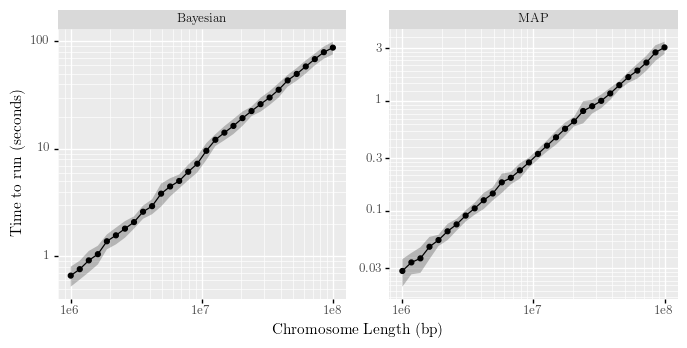

In [186]:
pn.options.figure_size = (8, 3.5)
plot = ggplot(df, aes(x='Length', y='mean')) + \
        geom_ribbon(aes(ymin='lower', ymax='upper', x='Length'), alpha=0.3) + \
        geom_point() + geom_line() + \
        scale_x_log10() + scale_y_log10() + facet_wrap('Method', ncol=2, scales = "free") + \
        labs(y= "Time to run (seconds)", x = "Chromosome Length (bp)") + theme_classic() + \
        theme(subplots_adjust={'wspace': 0.15},
              panel_grid_major = element_blank(),
              panel_grid_minor = element_blank(),
              strip_background = element_blank())

plot.save(folder + 'linear_time_lines.pdf')
fig = plot.draw()
fig.show()

### Li-Stephens vs Exact Decoding

In [14]:
# Python implementation of Li and Stephens' Method

def theta_tilde(n):
    """
    parameters:
    n - total number of sampled haplotypes
    """
    x = 1/np.arange(1,n)
    return 1/x.sum()

def get_emissions(haplotype_bank, theta, k):
    common_term = 0.5 * theta/(k+theta)
    equal = k/(k+theta) + common_term
    
    
    B0 = np.where(haplotype_bank == 0, equal, common_term)
    B1 = np.where(haplotype_bank == 1, equal, common_term)
    
    B = np.stack([B0.T, B1.T], 1)
    return np.log(B)

def setup_viterbi(df, m_locations, focal, panel, theta=None, rho_over_theta=1):
    n, S = df.shape
    
    if theta is None:
        theta = theta_tilde(n+1)
    rho = rho_over_theta * theta
    d = np.diff(m_locations)
        
    k = len(panel)   
    log_pi = np.log(np.repeat(1.0/k, k))
    
    obs = df[focal]
    haplotype_bank = df[panel]

    log_B = get_emissions(haplotype_bank, theta, k)
    return d, rho, log_B, log_pi, obs

def viterbi(d, rho, log_B, log_pi, obs, panel):
    L = len(obs)
    K = len(log_pi)
    T1 = np.zeros([L, K])
    T2 = np.zeros([L, K], dtype=int)
    T1[0] = log_pi + log_B[0,obs[0]] 
    
    for i in range(1,L):
        row = np.repeat(-np.expm1(-rho*d[i-1]/K)/K, K)
        A = np.tile(row, (K,1))
        np.fill_diagonal(A, np.diag(A) + np.exp(-rho*d[i-1]/K))
        log_T = np.log(A)

        prob = T1[i-1][:,None] + log_T + log_B[i,obs[i]]
        T1[i] = np.max(prob, axis=0)
        T2[i] = np.argmax(prob, axis=0)
    
    Z = np.zeros(L, dtype=int)
    Z[L-1] = np.argmax(T1[L-1])
    
    Z_panel = np.zeros(L, dtype=int)
    Z_panel[L-1] = panel[Z[L-1]]
    
    for i in range(L - 1, 0, -1):
        Z[i - 1] = T2[i, Z[i]]
        Z_panel[i - 1] = panel[Z[i - 1]] 
    return Z_panel, T1

def get_viterbi(df, m_locations, focal, panel, theta=None, rho_over_theta=1):
    d, rho, log_B, log_pi, obs = setup_viterbi(df, m_locations, focal, panel, theta, rho_over_theta)
    return viterbi(d, rho, log_B, log_pi, obs, panel)

def to_pp_ls(path, m_locations, L):
    x = np.r_[m_locations, L]
    return PPoly(x=x, c=path[None])

def to_pp_xsmc(seg):
    x = np.array(
            [seg.segments[0].interval[0]] + [s.interval[1] for s in seg.segments]
        )
    c = np.array([s.hap for s in seg.segments])[None]
    return PPoly(x=x, c=c)

def proportion_correct(ts, focal, Z, offset):
    check_set = [list(tree.leaves(tree.get_parent(focal))) for tree in ts.trees()]
    end = [round(tree.interval[1]) for tree in ts.trees()]
    count = 0
    i = 0
    while end[i] < offset:
        i += 1
    
    for j in range(len(Z)):
        if offset + j == end[i]:
            i += 1
        if Z[j] in check_set[i]:
            count += 1
    return count/(ts.sequence_length-offset)

In [24]:
ns = [3,5,11,26,101]
chroms = [10,13]

engine = stdpopsim.get_engine('msprime')
species = stdpopsim.get_species("HomSap")
demo = stdpopsim.PiecewiseConstantSize(species.population_size)

# def simulate(n, chrom, seed):
#     contig = species.get_contig(f'chr{chrom}')
#     r = contig.recombination_map.get_rates()[0]
#     mu = contig.mutation_rate
#     ts = msp.simulate(
#         sample_size=n,
#         mutation_rate=mu,
#         recombination_rate=r,
#         Ne=N0,
#         length=L,
#         random_seed=seed)
#     return ts, r, mu

def simulate(n, chrom, seed):
    samples = demo.get_samples(n)
    contig = species.get_contig(f'chr{chrom}')
    r = contig.recombination_map.get_rates()[0]
    mu = contig.mutation_rate
    
    ts = engine.simulate(demo, contig, samples, seed=seed)
    return ts, r, mu
    
def one_run(n, chrom, seed, default=True):
    ts, r, mu = simulate(n, chrom, seed)
    positions = np.array([int(v.position) for v in ts.variants()])
    df = ts.genotype_matrix().T
    focal = 0
    panel = list(range(1,n))
    
    if default:
        theta=None
        theta_LS = None
        rho_over_theta=1
    else:
        theta=mu*N0
        theta_LS=2*theta
        rho_over_theta=r/mu
    
    y_ls, T1 = get_viterbi(df, positions, focal, panel, theta_LS, rho_over_theta)
    xs = XSMC(ts, focal=focal, panel=panel, theta=theta, rho_over_theta=rho_over_theta)
    path = xs.viterbi(-np.log(xs.rho))
    x = np.arange(positions[0],ts.sequence_length).astype(int)
    y_xs = to_pp_xsmc(path)(positions).astype(int)

    i = 0
    m_ls = []
    m_xs = []
    for t in ts.trees():
        while i < len(positions) and positions[i] < t.interval[1]:
            m_xs.append(t.get_tmrca(focal, y_xs[i]))
            m_ls.append(t.get_tmrca(focal, y_ls[i]))
            i += 1
            
    A = np.array(m_xs) - np.array(m_ls)
    denominator = (A!=0).sum()
    numerator = (A<0).sum()
    return numerator/denominator, 1 - denominator/len(positions)

In [25]:
num_sim = 25
win_p = np.empty((len(ns), len(chroms), num_sim))
agree_p = np.empty((len(ns), len(chroms), num_sim))

for i,n in enumerate(ns):
    for j,chrom in enumerate(chroms):
        for k in range(num_sim):
            win_p[i,j,k], agree_p[i,j,k] = one_run(n, chrom, k+1)

0 0


/home/caleb/Desktop/Git/exact_smc/venv/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log
2020-09-11 13:05:20,159 DEBUG xsmc.xsmc MainThread Estimated θ=0.000373
2020-09-11 13:05:20,159 DEBUG xsmc.xsmc MainThread Setting window size w=26.000000
2020-09-11 13:06:26,663 DEBUG xsmc.xsmc MainThread Estimated θ=0.000508
2020-09-11 13:06:26,664 DEBUG xsmc.xsmc MainThread Setting window size w=19.000000


0 1


2020-09-11 13:07:24,315 DEBUG xsmc.xsmc MainThread Estimated θ=0.000373
2020-09-11 13:07:24,315 DEBUG xsmc.xsmc MainThread Setting window size w=26.000000
2020-09-11 13:08:05,687 DEBUG xsmc.xsmc MainThread Estimated θ=0.000514
2020-09-11 13:08:05,687 DEBUG xsmc.xsmc MainThread Setting window size w=19.000000


1 0


2020-09-11 13:10:07,144 DEBUG xsmc.xsmc MainThread Estimated θ=0.000488
2020-09-11 13:10:07,145 DEBUG xsmc.xsmc MainThread Setting window size w=20.000000
2020-09-11 13:12:36,531 DEBUG xsmc.xsmc MainThread Estimated θ=0.000519
2020-09-11 13:12:36,532 DEBUG xsmc.xsmc MainThread Setting window size w=19.000000


1 1


2020-09-11 13:14:14,826 DEBUG xsmc.xsmc MainThread Estimated θ=0.000491
2020-09-11 13:14:14,827 DEBUG xsmc.xsmc MainThread Setting window size w=20.000000
2020-09-11 13:15:37,675 DEBUG xsmc.xsmc MainThread Estimated θ=0.000516
2020-09-11 13:15:37,675 DEBUG xsmc.xsmc MainThread Setting window size w=19.000000


In [26]:
means = np.average(win_p, axis=2)
ses = sem(win_p, axis=2)
entries = mfunc(means, ses, 4)

In [27]:
columns = ['Chromosome 10', 'Chromosome 13']
df = pd.DataFrame(data=entries, columns=columns)
df['Panel Size'] = np.array(ns)-1
df = df.set_index('Panel Size').T
df.to_latex(folder + 'ls_win.tex')
display(df)

Panel Size,2,4
Chromosome 10,0.7017 (0.0033),0.7918 (0.0045)
Chromosome 13,0.7099 (0.0010),0.8160 (0.0085)


In [28]:
means = np.average(agree_p, axis=2)
ses = sem(agree_p, axis=2)
entries = mfunc(means, ses, 4)

In [29]:
columns = ['Chromosome 10', 'Chromosome 13']
df = pd.DataFrame(data=entries, columns=columns)
df['Panel Size'] = np.array(ns)-1
df = df.set_index('Panel Size').T
df.to_latex(folder + 'ls_agree.tex')
display(df)

Panel Size,2,4
Chromosome 10,0.9404 (0.0369),0.6935 (0.0219)
Chromosome 13,0.9403 (0.0358),0.6852 (0.0204)
